
# Autoencoder 와 KNN 을 이용한 Credit Card Fraud Detection

- [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) - Kaggle


- Highly Imbalanced Dataset - dataset는 2013 년 9 월 유럽 카드 소지자 신용 카드 거래로 만들었습니다. 이 dataset는 2 일 동안 발생한 거래를 보여 주며, 284,807 건의 거래 중 492 건의 fraud가 있습니다. 데이터세트는 매우 불균형하며 포지티브 클래스(사기)는 모든 거래의 0.172 %를 차지합니다.


- 이 dataset는 PCA 변환의 결과인 숫자 입력 변수만 포함합니다. 안타깝게도 기밀 유지 문제로 인해 데이터에 대한 원래 feature와 추가 background 정보를 제공할 수 없습니다. 특성 V1, V2, ... V28은 PCA로 얻은 principal component이며 PCA로 변환되지 않은 유일한 기능은 'Time' 과 'Amount' 입니다. 'time' 특성은 각 트랜잭션과 데이터 세트의 첫 번째 트랜잭션 사이에 경과된 시간(초) 입니다. 'Amount' 특성은 거래금액 입니다. 



- 'Class'는 사기의 경우 1, 그렇지 않으면 0 입니다.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.utils import plot_model

np.random.seed(0)
tf.random.set_seed(0)

## Downloading of dataset

In [2]:
df = pd.read_csv("data/creditcard.csv")
# df = pd.read_csv( 'https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


- the dataset is highly unbalanced

In [3]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [4]:
fraud = (df['Class'] == 1).sum()
normal = (df['Class'] == 0).sum()

total = fraud + normal

print(f"Total = {total:,}")
print(f"Fraud = {fraud/total*100:,.2f}%")
print(f"Normal = {normal/total*100:,.2f}%")

Total = 284,807
Fraud = 0.17%
Normal = 99.83%


- Time 필드를 일중 시간으로 변환합니다.   
- Amount 필드는 로그 스케일로 변환합니다.

In [5]:
df.loc[:, "Time"]   = df.loc[:, "Time"].apply(lambda x : x / 3600 % 24) #일중 시간
df.loc[:, 'Amount'] = np.log(df.loc[:, 'Amount'] + 1)

- class 1 이 너무 적으므로 통상적인 7:3 대신 5:5 비율로 train, test set 분리

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Class', axis=1), df['Class'], 
                                                    test_size=0.5, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((142403, 30), (142404, 30), (142403,), (142404,))

In [7]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train.values)
X_test  = sc.transform(X_test.values)

In [8]:
y_test.value_counts() / y_test.count()

0    0.998294
1    0.001706
Name: Class, dtype: float64

In [9]:
y_train.value_counts() / y_train.count()

0    0.998251
1    0.001749
Name: Class, dtype: float64

## Autoencoder Train

- 정상 거래로만 오토 인코더를 교육합니다.   

- Autoencoder 의 encoder 부분을 feature extractor 로 이용

In [12]:
X_train_normal = X_train[y_train == 0]
X_train_fraud = X_train[y_train == 1]

X_train_normal.shape, X_train_fraud.shape

((142154, 30), (249, 30))

In [13]:
X_test_normal = X_test[y_test == 0]
X_test_fraud = X_test[y_test == 1]

X_test_normal.shape, X_test_fraud.shape

((142161, 30), (243, 30))

## DNN model 작성

## autoencoder의 인코더 부분 및 k-NN / SVC 사용

훈련 데이터세트의 모든 사례 (사기/정상)를 사용하여 훈련하고 그 결과를 사용하여 인스턴스들을 12 차원 공간에 매핑합니다. 매핑된 케이스는 분류를 위해 k-NN 혹은 SVM에 공급됩니다.

In [19]:
input_layer = Input(shape=(30, ))

encoded_all = Dense(12, activation='relu')(input_layer)
decoded_all = Dense(30, activation='linear')(encoded_all)

encoder_all = Model(input_layer, encoded_all)
autoencoder_all = Model(input_layer, decoded_all)

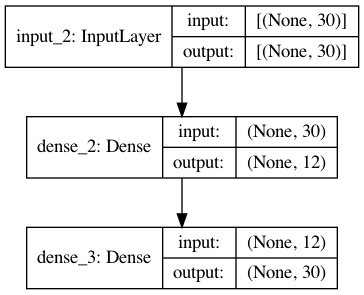

In [21]:
plot_model(autoencoder_all, show_shapes=True)

In [22]:
autoencoder_all.compile(optimizer='adam', loss='mse')
history = autoencoder_all.fit(X_train, X_train, epochs = 30, 
                              batch_size=128, validation_data=(X_test, X_test))

Epoch 1/30
1113/1113 [==============================] - 1s 941us/step - loss: 0.9094 - val_loss: 0.6085
Epoch 2/30
1113/1113 [==============================] - 1s 831us/step - loss: 0.5951 - val_loss: 0.5655
Epoch 3/30
1113/1113 [==============================] - 1s 833us/step - loss: 0.5574 - val_loss: 0.5606
Epoch 4/30
1113/1113 [==============================] - 1s 832us/step - loss: 0.5602 - val_loss: 0.5607
Epoch 5/30
1113/1113 [==============================] - 1s 808us/step - loss: 0.5589 - val_loss: 0.5601
Epoch 6/30
1113/1113 [==============================] - 1s 853us/step - loss: 0.5680 - val_loss: 0.5610
Epoch 7/30
1113/1113 [==============================] - 1s 853us/step - loss: 0.5557 - val_loss: 0.5604
Epoch 8/30
1113/1113 [==============================] - 1s 862us/step - loss: 0.5538 - val_loss: 0.5611
Epoch 9/30
1113/1113 [==============================] - 1s 821us/step - loss: 0.5503 - val_loss: 0.5610
Epoch 10/30
1113/1113 [==============================] - 1s 866u

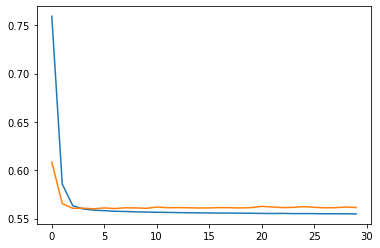

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

## KNN, SVC
- train input 으로 사용하기 위한 encoder output 출력

In [25]:
enc_all = encoder_all.predict(X_train)
enc_all.shape

(142403, 12)

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

model_svc = SVC()
model_knn = KNeighborsClassifier(n_neighbors=3)

In [27]:
# Train the model using the training sets
model_svc.fit(enc_all, y_train)

SVC()

In [28]:
model_knn.fit(enc_all, y_train)

KNeighborsClassifier(n_neighbors=3)

In [29]:
%%time
predicted_svc = model_svc.predict(encoder_all.predict(X_test))
predicted_svc

CPU times: user 19.3 s, sys: 259 ms, total: 19.5 s
Wall time: 19.1 s


array([0, 0, 0, ..., 0, 0, 0])

In [30]:
%%time
predicted_knn = model_knn.predict(encoder_all.predict(X_test))
predicted_knn

CPU times: user 1min 12s, sys: 421 ms, total: 1min 12s
Wall time: 1min 12s


array([0, 0, 0, ..., 0, 0, 0])

## DNN

In [31]:
model_dnn = tf.keras.Sequential([
      tf.keras.layers.Dense(32, activation='relu', input_shape=(enc_all.shape[-1],)),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(16, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(1, activation='sigmoid'),
  ])

model_dnn.compile(
      optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
      loss = 'binary_crossentropy', metrics=['accuracy'])

In [32]:
enc_test = encoder_all.predict(X_test)

In [33]:
history = model_dnn.fit(enc_all, y_train, epochs=50, batch_size=1024, 
                    validation_data=(enc_test, y_test))

Epoch 1/50
140/140 [==============================] - 1s 3ms/step - loss: 0.2767 - accuracy: 0.9322 - val_loss: 0.0284 - val_accuracy: 0.9983
Epoch 2/50
140/140 [==============================] - 0s 2ms/step - loss: 0.0336 - accuracy: 0.9982 - val_loss: 0.0136 - val_accuracy: 0.9983
Epoch 3/50
140/140 [==============================] - 0s 2ms/step - loss: 0.0154 - accuracy: 0.9985 - val_loss: 0.0081 - val_accuracy: 0.9988
Epoch 4/50
140/140 [==============================] - 0s 2ms/step - loss: 0.0133 - accuracy: 0.9984 - val_loss: 0.0074 - val_accuracy: 0.9989
Epoch 5/50
140/140 [==============================] - 0s 2ms/step - loss: 0.0099 - accuracy: 0.9986 - val_loss: 0.0066 - val_accuracy: 0.9991
Epoch 6/50
140/140 [==============================] - 0s 2ms/step - loss: 0.0083 - accuracy: 0.9988 - val_loss: 0.0058 - val_accuracy: 0.9991
Epoch 7/50
140/140 [==============================] - 0s 1ms/step - loss: 0.0068 - accuracy: 0.9989 - val_loss: 0.0056 - val_accuracy: 0.9991
Epoch 

In [34]:
predicted_dnn = model_dnn.predict(encoder_all.predict(X_test)) > 0.5

Precision 0.90
Recall 0.67


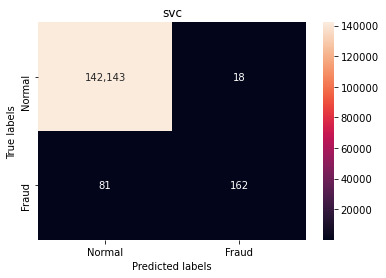

Precision 0.91
Recall 0.73


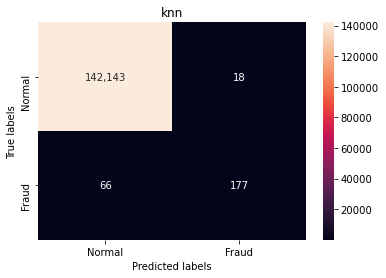

Precision 0.84
Recall 0.75


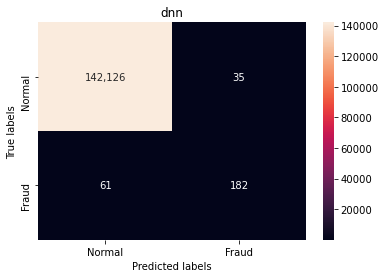

In [38]:
for model, predicted in [("svc", predicted_svc), 
                         ("knn", predicted_knn), 
                         ("dnn", predicted_dnn)]:
    
    print("Precision {:.2f}".format(metrics.precision_score(y_test, predicted)))
    print("Recall {:.2f}".format(metrics.recall_score(y_test, predicted)))
    
    cm = metrics.confusion_matrix(y_test, predicted)

    ax = sns.heatmap(cm, annot=True, fmt=',')
    ax.set_xlabel('Predicted labels'); 
    ax.set_ylabel('True labels')
    ax.set_title(model); 
    ax.xaxis.set_ticklabels(['Normal', 'Fraud']); 
    ax.yaxis.set_ticklabels(['Normal', 'Fraud']);
    ax.set(yticks=[0.5, 1.5], 
           xticks=[0.5, 1.5])
    plt.show()